In [1740]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import re


from sklearn.model_selection import train_test_split

# K Means Clustering
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# DT 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV 

# Boosted DT 
from sklearn.ensemble import AdaBoostRegressor

# Scaler for ANN
from sklearn.preprocessing import StandardScaler

# Random Forest
from sklearn.ensemble import RandomForestRegressor 


# ANN
from sklearn.neural_network import MLPRegressor

# KMeans 
from sklearn.cluster import KMeans

# SVM
from sklearn.svm import SVR 

# KNN
from sklearn.neighbors import KNeighborsRegressor 

import scipy

import xgboost

In [1741]:
os.listdir()


['Movie_Rankings.csv',
 'imdb_updated',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Ranked.csv',
 '~$Movies_2020.xlsx',
 'Movies_Updated.ipynb',
 'IMDB',
 '.ipynb_checkpoints',
 'Movies - Personal Inquiry.ipynb',
 'Movies.csv',
 'MLR_Movies.ipynb']

In [1742]:
data = pd.read_excel('Movies_2020.xlsx', 
                    dtype = {'ReleaseYear': int}
                    )

In [1743]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama


In [1744]:
print("There are ",data.shape[0], " movies in this dataset")

There are  165  movies in this dataset


In [1745]:
data.dtypes

Name                   object
Rating                float64
WatchDate      datetime64[ns]
ReleaseYear             int64
Director               object
Genre                  object
dtype: object

In [1746]:
data.isna().sum()

Name           0
Rating         0
WatchDate      0
ReleaseYear    0
Director       0
Genre          0
dtype: int64

#### The movie watchings are skewed heavily toward recent movies, with some noticable peaks in 1950s (due to Hitchcock & Audrey Hepburn films)

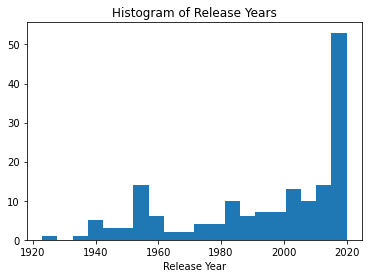

In [1747]:
plt.hist(data['ReleaseYear'], bins = 20)
plt.xlabel('Release Year')
plt.title("Histogram of Release Years")
plt.show()

#### The Ratings also show that I generally rate movies highly, this distribution is right-skewed as well

In [1748]:
data['Rating'].describe()

count    165.000000
mean       0.791212
std        0.140529
min        0.250000
25%        0.700000
50%        0.850000
75%        0.900000
max        0.990000
Name: Rating, dtype: float64

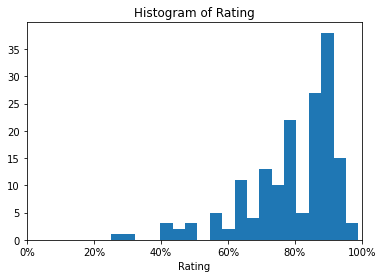

In [1749]:
plt.hist(data['Rating'], bins = 20)
plt.xlabel('Rating')
plt.xlim(0, 1)
plt.title("Histogram of Rating")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

#### My movie intake is quite high during the 2020 Global Covid-19 Pandemic. It also was pretty high in early 2016, as I was in my senior spring of college. This charts the quarterly sum of movies. 

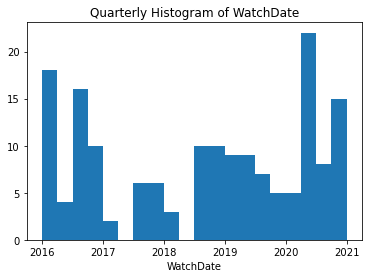

In [1750]:
plt.hist(data['WatchDate'], bins = 20)
plt.xlabel('WatchDate')
plt.title("Quarterly Histogram of WatchDate")
plt.show()

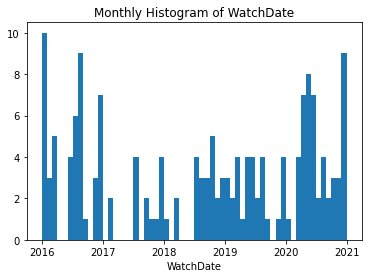

In [1751]:
plt.hist(data['WatchDate'], bins = 60)
plt.xlabel('WatchDate')
plt.title("Monthly Histogram of WatchDate")
plt.show()

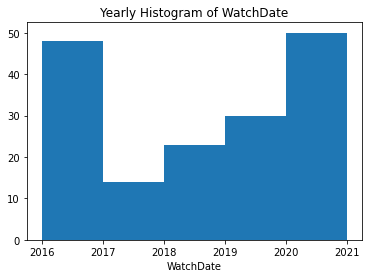

In [1752]:
plt.hist(data['WatchDate'], bins = 5)
plt.xlabel('WatchDate')
plt.title("Yearly Histogram of WatchDate")
plt.show()

#### What is my average rating over time?

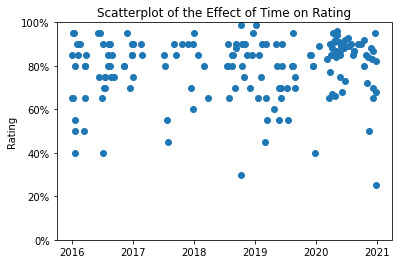

In [1753]:
plt.scatter(data['WatchDate'], data['Rating'])
plt.title("Scatterplot of the Effect of Time on Rating")
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### Am I watching newer movies over time?

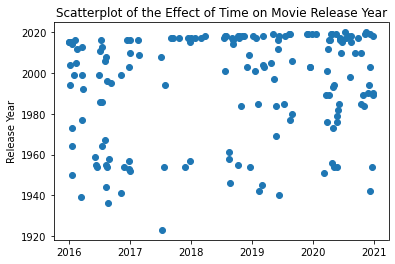

In [1762]:
plt.scatter(data['WatchDate'], data['ReleaseYear'])
plt.title("Scatterplot of the Effect of Time on Movie Release Year")
plt.ylabel('Release Year')
plt.show()

#### Create a Monthly Aggregation to Summarize Trends

In [1763]:

data['WatchMonth'] = data['WatchDate'].values.astype('datetime64[M]')

data_month = data.groupby(['WatchMonth']).agg(
                    count = pd.NamedAgg( column = 'Name', aggfunc = 'count'),
                    rating = pd.NamedAgg( column = 'Rating', aggfunc = 'mean'),
                    movieyear = pd.NamedAgg( column = 'ReleaseYear', aggfunc = 'mean')
                )
data_month = data_month.reset_index()
#data_month.rename(columns = {'Name':'Count'}, inplace = True)
data_month.head()


,WatchMonth,count,rating,movieyear
0,2016-01-01,10,0.720000,1994.30
1,2016-02-01,3,0.883333,2011.00
2,2016-03-01,5,0.720000,1984.00
3,2016-06-01,4,0.825000,1966.75
4,2016-07-01,6,0.700000,1996.00


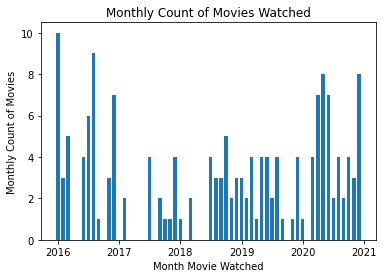

In [1764]:
plt.bar(data_month['WatchMonth'], data_month['count'], width = 20)
plt.xlabel('Month Movie Watched')
plt.ylabel('Monthly Count of Movies')
plt.title('Monthly Count of Movies Watched')
plt.show()

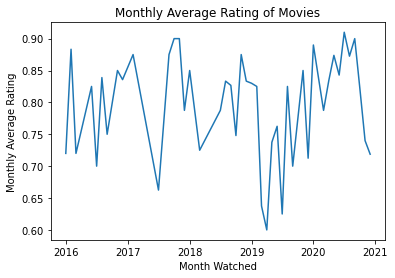

In [1765]:
plt.plot(data_month['WatchMonth'], data_month['rating'])
plt.title('Monthly Average Rating of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Rating')
plt.show()

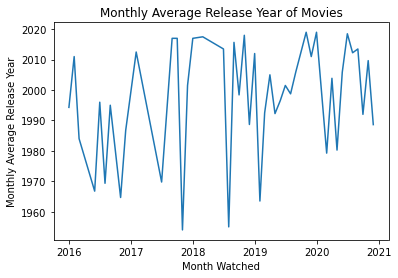

In [1766]:
plt.plot(data_month['WatchMonth'], data_month['movieyear'])
plt.title('Monthly Average Release Year of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Release Year')
plt.show()

#### Is there a relationship between Year of the Movie Release and my Rating?

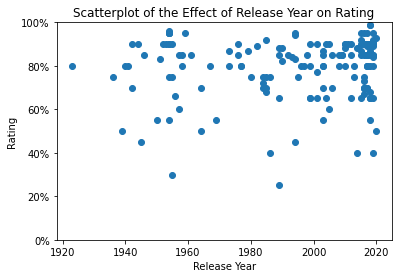

In [1767]:
plt.scatter(data['ReleaseYear'], data['Rating'])
plt.title('Scatterplot of the Effect of Release Year on Rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### What are my highest rated movies?

In [1768]:
data.sort_values(by=['Rating'], ascending = False).head(10)

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth
76,Colette,0.99,2018-10-12,2018,Wash Westmoreland,Historical/Drama,2018-10-01
85,On the Basis of Sex,0.99,2019-01-06,2018,Mimi Leder,Historical/Drama,2019-01-01
129,Rear Window,0.96,2020-05-05,1954,Alfred Hitchcock,Noir/Mystery,2020-05-01
61,The Big Sick,0.95,2017-12-30,2017,Michael Showalter,Romance/Drama,2017-12-01
20,Rear Window,0.95,2016-06-19,1954,Hitchcock,Thriller/Mystery,2016-06-01
40,White Christmas,0.95,2016-11-26,1954,Michael Curtiz,Romance/Musical,2016-11-01
123,Hidden Figures,0.95,2020-04-10,2016,Theodore Melfi,Drama/History,2020-04-01
84,White Christmas,0.95,2018-12-23,1954,Michael Curtiz,Romance/Comedy,2018-12-01
18,North by Northwest,0.95,2016-06-08,1959,Hitchcock,Mystery/Drama,2016-06-01
107,The Farewell,0.95,2019-08-17,2019,Lulu Wang,Drama/Comedy,2019-08-01


#### Which Director have I seen the most movies from?

In [1769]:
data['Director'].value_counts().head()

Hitchcock            6
Michael Curtiz       5
Damien Chazelle      4
Robert Zemeckis      4
Sylvester Stalone    3
Name: Director, dtype: int64

### Label Encoding the Genre Column 

In [1770]:
data[['Genre1','Genre2']] = data['Genre'].str.split('/',expand=True)

In [1771]:
data['Genre2'] = data['Genre2'].fillna('Genre1')

In [1772]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama


Due to the mispellings in the underlying dataset, do manual combinations to reduce the dimensionality of the dataset

In [1773]:

data['Romance_Ind'] = 0 
r = re.compile(r'.*(Romance).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Romance_Ind'] = 1
  
data['Comedy_Ind'] = 0 
r = re.compile(r'.*(Comedy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Comedy_Ind'] = 1
 
data['Drama_Ind'] = 0 
r = re.compile(r'.*(Drama).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Drama_Ind'] = 1

data['Thriller_Ind'] = 0 
r = re.compile(r'.*(Thriller).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Thriller_Ind'] = 1
 
data['Fantasy_Ind'] = 0 
r = re.compile(r'.*(Fantasy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Fantasy_Ind'] = 1

data['Crime_Ind'] = 0 
r = re.compile(r'.*(Crime).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Crime_Ind'] = 1

data['Sport_Ind'] = 0 
r = re.compile(r'.*(Sport).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Sport_Ind'] = 1

data['Historical_Ind'] = 0 
r = re.compile(r'.*(Historical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Historical_Ind'] = 1


data['Mystery_Ind'] = 0 
r = re.compile(r'.*(Mystery).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Mystery_Ind'] = 1


data['Action_Ind'] = 0 
r = re.compile(r'.*(Action).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Action_Ind'] = 1


data['Musical_Ind'] = 0 
r = re.compile(r'.*(Musical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Musical_Ind'] = 1


data['SciFi_Ind'] = 0 
r = re.compile(r'.*(Sci).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'SciFi_Ind'] = 1

data['Other_Ind'] = 0
data.loc[ (data['Romance_Ind'] == 0) & (data['Comedy_Ind'] == 0) & (data['Drama_Ind'] == 0) & \
          (data['Thriller_Ind'] == 0) & (data['Fantasy_Ind'] == 0) & (data['Crime_Ind'] == 0) & \
         (data['Sport_Ind'] == 0) & (data['Historical_Ind'] == 0) & (data['Mystery_Ind'] == 0) & \
         (data['Action_Ind'] == 0) & (data['Musical_Ind'] == 0 ) & (data['SciFi_Ind'] == 0)
         , 'Other_Ind'] = 1



In [1774]:
data.describe()

,Rating,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.791212,1994.006061,0.236364,0.327273,0.557576,0.078788,0.066667,0.054545,0.048485,0.042424,0.103030,0.042424,0.078788,0.066667,0.024242
std,0.140529,25.921904,0.426141,0.470646,0.498186,0.270228,0.250203,0.227782,0.215442,0.202169,0.304924,0.202169,0.270228,0.250203,0.154269
min,0.250000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.850000,2003.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,2017.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1775]:
data.iloc[:, 9:].sum()

Romance_Ind       39
Comedy_Ind        54
Drama_Ind         92
Thriller_Ind      13
Fantasy_Ind       11
Crime_Ind          9
Sport_Ind          8
Historical_Ind     7
Mystery_Ind       17
Action_Ind         7
Musical_Ind       13
SciFi_Ind         11
Other_Ind          4
dtype: int64

In [1776]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


#### Split the Data

In [1777]:
X = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind']]
y = data.loc[:, 'Rating']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = .30, train_size = .70, random_state = 42)
    

In [1778]:
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(115, 14)
(115,)
(50, 14)
(50,)


In [1779]:
X_Train.head()

,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
97,1984,0,1,1,0,0,0,0,0,0,0,0,0,0
11,2005,0,0,1,0,0,0,0,0,1,0,0,0,0
65,2017,1,0,1,0,0,0,0,0,0,0,0,0,0
86,2001,0,1,1,0,0,0,0,0,0,0,0,0,0
6,1950,0,0,1,0,0,0,0,0,0,0,1,0,0


#### We can't do Clustering on a Binary Dataset. We will have to get something else - such as 'Sentiment Score' using NLP Methods. 
#### Get Sentiment using NLTK, then use that as an input to Clustering 

### Decision Tree on Binary Genre + Release Year Data 

#### 1) Decision Tree

In [1780]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.6922432401726879
Mean Squared Error: 0.02648022222222222


Grid Search for Best Parameters

In [1781]:
def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['mse', 'mae','friedman_mse']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(3, 13, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeRegressor(random_state=42),
                       param_grid=param_grid, 
                       #scoring='neg_mean_squared_error',
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [1782]:
make_GridSearchCV_DT(X_Train, Y_Train)

0.02155379065851635
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 11, 'splitter': 'random'}


R2 Score: -0.04209011565235188
Mean Squared Error: 0.016306626129728004


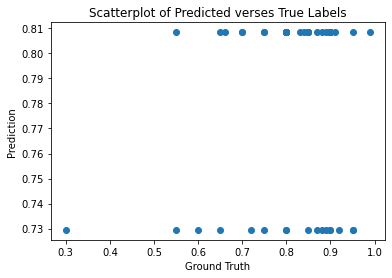

In [1787]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 1, min_samples_leaf = 11,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

In [1788]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.0029740379702594133
Mean Squared Error: 0.01569453774615862


In [1789]:
def make_GridSearchCV_Boosted_DT(X_Train, Y_Train):

    losses = ['linear', 'square', 'exponential']
    learning_rates = np.arange(0.5,1,step=0.10)
    num_est = np.arange(10,100,step=5)

    param_grid = {'loss': losses, 'learning_rate': learning_rates, 'n_estimators': num_est}

    classifier = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [1790]:
#make_GridSearchCV_Boosted_DT(X_Train, Y_Train)

R2 Score: -0.05142695462314695
Mean Squared Error: 0.016452728985943


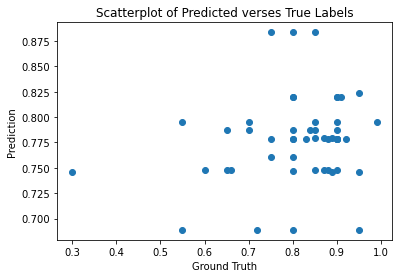

In [1791]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [1792]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -1.4170906511593397
Mean Squared Error: 0.03782263450934134


In [1793]:
# This one is only for the Polling Data 
def make_GridSearchCV_ANN(X_Train, Y_Train):
    
    activations = ['identity', 'relu', 'tanh', 'logistic']
    solvers = ['adam']
    hidden_layers = list(np.arange(5, 100, 5))
    
    init_learning_rates = [0.01, 0.05]
    
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPRegressor(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [1794]:
#make_GridSearchCV_ANN(X_Train, Y_Train)

R2 Score: -0.852392806129457
Mean Squared Error: 0.028986242630313745


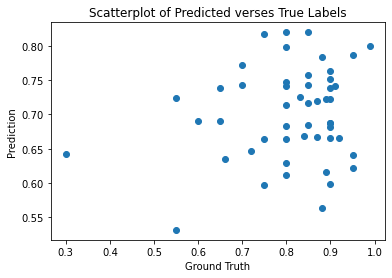

In [1795]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                          hidden_layer_sizes = 45, learning_rate_init = 0.01)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### We need to find some better features. Let's explore NLP Sentiment of the Movie Genre

### 1) NLTK Vader Compound Score

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [1796]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def show_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [1797]:
print(data.loc[0,['Genre1']])

word = str(data.loc[0,['Genre1']])
show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 


In [1798]:
for i in range(0, 5):
    print(data.loc[i,['Genre1']])

    word = str(data.loc[i,['Genre1']])
    show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Fantasy
Name: 1, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Romance
Name: 2, dtype: object
compound: 0.5574, 
neg: 0.0, 
neu: 0.581, 
pos: 0.419, 
Genre1    Comedy
Name: 3, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 
Genre1    Comedy
Name: 4, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 


In [1799]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    return (ss['compound'])


In [1800]:
# Apply this function to my Genre Columns
data['Genre1_NLTK'] = data['Genre1'].apply(get_vader_score)
data['Genre2_NLTK'] = data['Genre2'].apply(get_vader_score)
data['Genre_NLTK'] = (data['Genre1_NLTK'] + data['Genre2_NLTK']) / 2

#### Much of the NLTK Vader Compound Scores are Zero - let us look for a wider range of scores with other Libraries

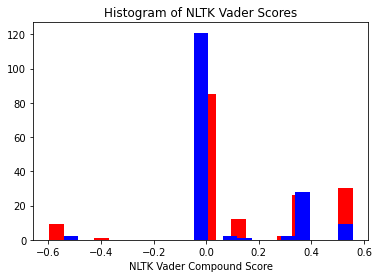

In [1801]:
plt.hist(data['Genre1_NLTK'], bins = 20, color = 'red')
plt.hist(data['Genre2_NLTK'], bins = 20, color = 'blue')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

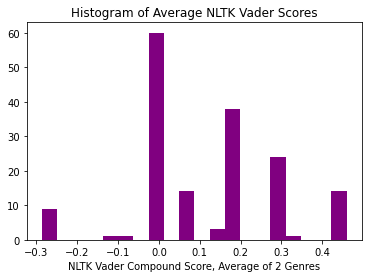

In [1802]:
plt.hist(data['Genre_NLTK'], bins = 20, color = 'purple')
plt.xlabel('NLTK Vader Compound Score, Average of 2 Genres')
plt.title('Histogram of Average NLTK Vader Scores')
plt.show()

### 2) Textblob Polarity Score

In [1803]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [1804]:
data['Genre1_TB'] = data['Genre1'].apply(get_textBlob_score)
data['Genre2_TB'] = data['Genre2'].apply(get_textBlob_score)
data['Genre_TB'] = (data['Genre1_TB'] + data['Genre2_TB']) / 2

#### Textblob Scores are even less spread out than NLTK Vader Scores

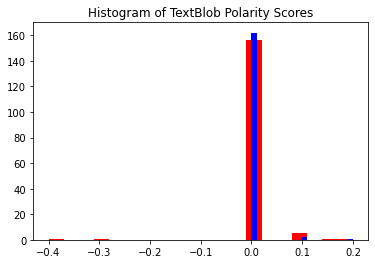

In [1805]:
plt.hist(data['Genre1_TB'], bins = 20, color = 'red')
plt.hist(data['Genre2_TB'], bins = 20, color = 'blue')

plt.title('Histogram of TextBlob Polarity Scores')
plt.show()

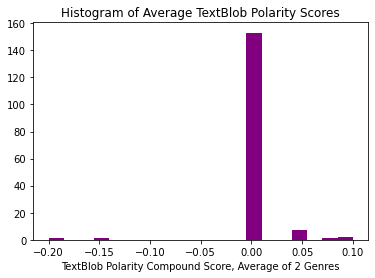

In [1806]:
plt.hist(data['Genre_TB'], bins = 20, color = 'purple')
plt.xlabel('TextBlob Polarity Compound Score, Average of 2 Genres')
plt.title('Histogram of Average TextBlob Polarity Scores')
plt.show()

### 3) SpaCy Sentiment 

In [1807]:
import spacy



In [1808]:
#!python -m spacy download en

#spacy.load('en_core_web_sm')
nlp_spacy = spacy.load('en')

docs = nlp_spacy('romance comedy action crime drama horror musical')

for word in docs:
    print(word.text,word.pos_, word.sentiment)

romance NOUN 0.0
comedy PROPN 0.0
action NOUN 0.0
crime NOUN 0.0
drama NOUN 0.0
horror NOUN 0.0
musical ADJ 0.0


#### Examine NLTK vs Rating

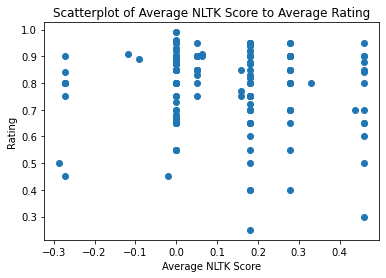

In [1809]:
plt.scatter(data['Genre_NLTK'], data['Rating'])
plt.xlabel('Average NLTK Score')
plt.ylabel('Rating')
plt.title('Scatterplot of Average NLTK Score to Average Rating')
plt.show()

#### Examine NLTK vs Release Year

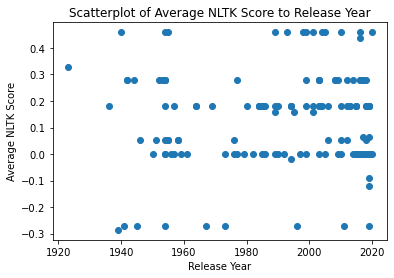

In [1810]:
plt.scatter(data['ReleaseYear'], data['Genre_NLTK'])
plt.ylabel('Average NLTK Score')
plt.xlabel('Release Year')
plt.title('Scatterplot of Average NLTK Score to Release Year')
plt.show()

### Revisit Clustering Algorithms, Using NLTK Vader Compound Genre Score + Movie Release Year to Determine the Clusters 

### Cluster Using These Methods:
- K Means
- Expectation Maximization
- Heirarchical

### 1) K-Means

#### How many clusters should we pick? Use Elbow Method 

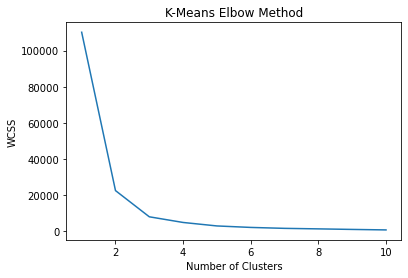

In [1811]:
X = data.loc[:, ['ReleaseYear','Genre_NLTK']].values

# Use elbow method to find optimal number of Clusters 

wcss = [] 

# fit KMeans to our data X 
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 43)
    kmeans.fit(X)
    # compute WCSS and append to our list, also called 'Inertia' in KMeans class 
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [1813]:
#import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

We want to Maximize Silhouette Score and Minimize Inertia - find place where Inertia is no longer decreasing as fast. 

<Figure size 432x288 with 0 Axes>

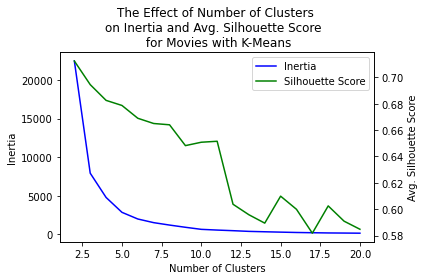

In [1814]:
run_kmeans(X, np.arange(2, 21, 1), "Movies")

### K-Means results:
- Elbow method suggests K = 3 clusters
- Silhouette score is still higher for K = 11 clusters

#### K Means with K = 3

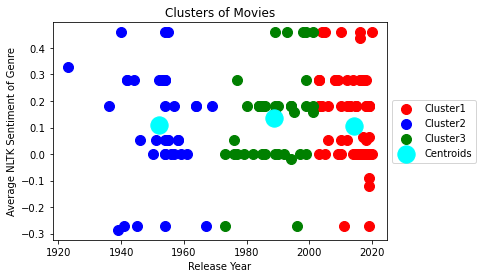

In [1815]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)
#print(Y_kmeans)

#print(Y_kmeans.shape)
#print(X.shape)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 11

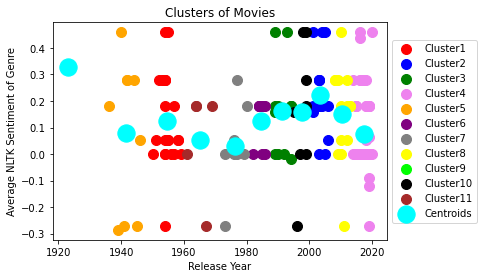

In [1816]:
kmeans = KMeans(n_clusters = 11, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_kmeans == 9, 0], X[Y_kmeans == 9, 1], s = 100, color = 'black', label = 'Cluster10')
plt.scatter(X[Y_kmeans == 10, 0], X[Y_kmeans == 10, 1], s = 100, color = 'brown', label = 'Cluster11')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### The above results are not useful because we did not SCALE the data - only the movie Release Year is dividing up our dataset! 

<Figure size 432x288 with 0 Axes>

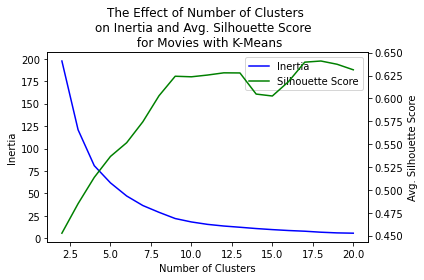

In [1817]:
# Use Feature scaling 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
#X_scaled = sc_X.fit_transform(X)
X = sc_X.fit_transform(X)

run_kmeans(X, np.arange(2, 21, 1), "Movies")

- K = 4 looks like a kink in the elbow, otherwise K = 9 

#### K-Means with K = 4, Scaled Data

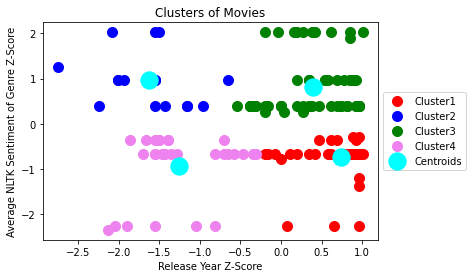

In [1818]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 9, Scaled Data

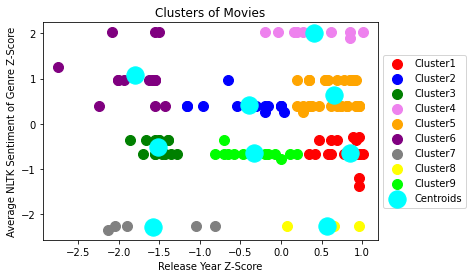

In [1819]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)


plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1820]:
data['KMeans_Cluster'] = Y_kmeans

In [1821]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,3
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,1
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,4


### 2) Expectation Maximization

In [1822]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()


Covariance type: full


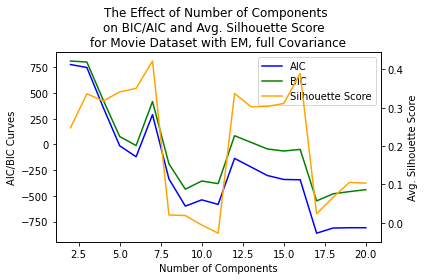

Covariance type: tied


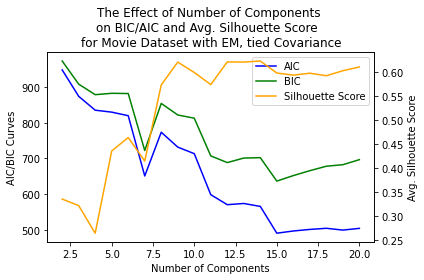

Covariance type: diag


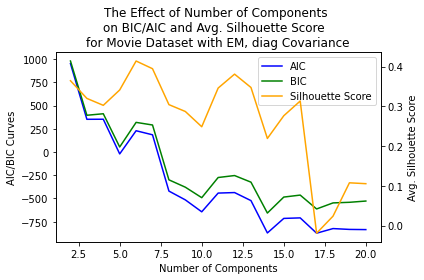

Covariance type: spherical


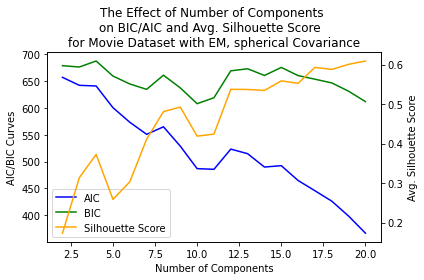

In [1823]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X, np.arange(2, 21, 1), "Movie Dataset", cv)

- full: K = 7
- tied: K = 10
- diag: K = 6 
- spherical: K = 7 or 8 


#### Try Tied Covariance with K = 10, this has a high separation of clusters, as determined by the higher Silhouette Score. This shows us how far apart the clusters are. 

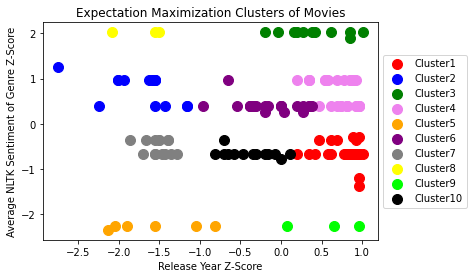

In [1824]:
em = EM(n_components = 10, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_em == 9, 0], X[Y_em == 9, 1], s = 100, color = 'black', label = 'Cluster10')

# Add the centroids - Compute for EM, the centroid is point with the maximum density 
#centers = np.empty(shape=(em.n_components, X.shape[1]))
#for i in range(em.n_components):
#    density = scipy.stats.multivariate_normal(cov=em.covariances_[i], mean=em.means_[i]).logpdf(X)
#    centers[i, :] = X[np.argmax(density)]
#plt.scatter(centers[:, 0], centers[:, 1], s=20)

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The cluster 9 looks quite small. It may be better to have fewer clusters 

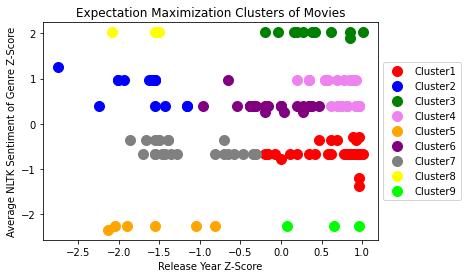

In [1825]:
em = EM(n_components = 9, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1826]:
data['EM_Cluster'] = Y_em

### 3) Hierarchical Clustering 

#### Use Dendrogram to find optimal cluster size - Pick longest Vertical Line. Then, if a horizontal line was drawn through this line, how many cluster groups would we have? 

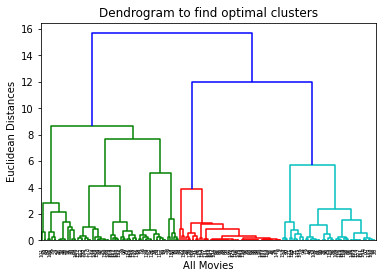

In [1827]:
import scipy.cluster.hierarchy as sch

# Ward tries to minimize variance within cluster. Similar to WCSS for KMeans.
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward' ))

plt.title('Dendrogram to find optimal clusters')
plt.xlabel('All Movies')
plt.ylabel('Euclidean Distances')
plt.show()

- Pick line. Looks like 7 Clusters

#### Hierarchical Clustering with K = 7

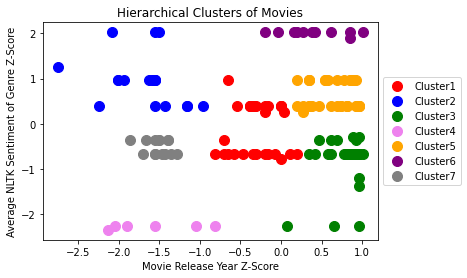

In [1828]:
from sklearn.cluster import AgglomerativeClustering 

# Prepare hc algorithm 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
Y_hc = hc.fit_predict(X)

plt.scatter(X[Y_hc == 0, 0], X[Y_hc == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_hc == 1, 0], X[Y_hc == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_hc == 2, 0], X[Y_hc == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_hc == 3, 0], X[Y_hc == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_hc == 4, 0], X[Y_hc == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_hc == 5, 0], X[Y_hc == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_hc == 6, 0], X[Y_hc == 6, 1], s = 100, color = 'gray', label = 'Cluster7')


plt.title('Hierarchical Clusters of Movies')
plt.xlabel('Movie Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1829]:
data['Hierarchical_Cluster'] = Y_hc

In [1830]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,3,2,5
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,1,5,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,4,3,4


### Use Cluster Number, Movie Release Year, and Average NLTK Sentiment as Inputs into Decision Trees and other Regression Methods - See how this improves from earlier when we had no clusters 

Split Data

In [1831]:
X_aug = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind','Genre_NLTK','KMeans_Cluster']]
y_aug  = data.loc[:, 'Rating']

X_Train_aug, X_Test_aug, Y_Train_aug, Y_Test_aug = train_test_split(X_aug, y_aug, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree with Augmented Data

In [1832]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.5782989661440581
Mean Squared Error: 0.024697222222222218


Grid Search on New Datasets

In [1833]:
make_GridSearchCV_DT(X_Train_aug, Y_Train_aug)

0.021553790658516148
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 11, 'splitter': 'random'}


R2 Score: -0.020449897750511203
Mean Squared Error: 0.015967999999999996


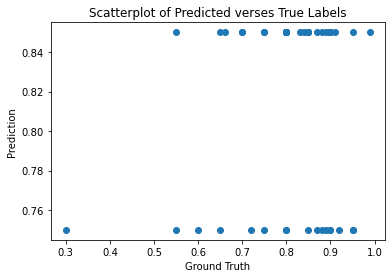

In [1837]:
dt_model = DecisionTreeRegressor(criterion = 'mae', splitter = 'random', 
                                 max_depth = 1, min_samples_leaf = 11,
                                 random_state = 42)

dt_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

This chart shows Decision Tree is only giving us 4 possible predicted values - which makes sense, given tree stops at depth of 3

#### 2) Boosted Decision Tree w/ Augmented Data

Default

In [1838]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train_aug, Y_Train_aug)
Y_Test_Pred = boosted_dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.0900256031172535
Mean Squared Error: 0.017056720637578782


In [1839]:
#make_GridSearchCV_Boosted_DT(X_Train_aug, Y_Train_aug)

Best Params

R2 Score: -0.12706994300273067
Mean Squared Error: 0.01763639046810673


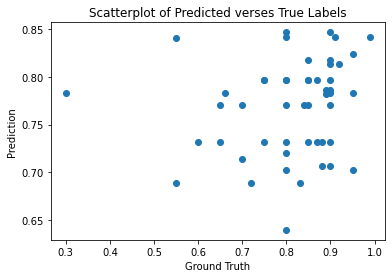

In [1841]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.9, loss = 'exponential', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train_aug, Y_Train_aug)
Y_Test_Pred = boosted_dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [1842]:
sc = StandardScaler()
X_Train_aug = sc.fit_transform(X_Train_aug)
X_Test_aug = sc.transform(X_Test_aug)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = ann_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test_aug, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_aug, Y_Test_Pred))

R2 Score: -1.7599321252046187
Mean Squared Error: 0.04318741789520187


In [1843]:
#make_GridSearchCV_ANN(X_Train_aug, Y_Train_aug)

Best Params

R2 Score: -0.303038581379399
Mean Squared Error: 0.020389947721424835


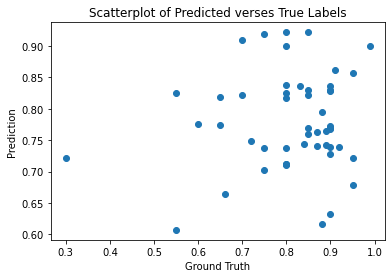

In [1844]:
sc = StandardScaler()
X_Train_aug = sc.fit_transform(X_Train_aug)
X_Test_aug = sc.transform(X_Test_aug)

ann_model =  MLPRegressor(activation = 'identity', solver = 'adam', random_state = 42, \
                          hidden_layer_sizes = 15, learning_rate_init = 0.05)

ann_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = ann_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test_aug, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_aug, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### Maybe it is a dimensionality problem? 


In [1845]:
X_nlp = data.loc[:, ['ReleaseYear','Genre_NLTK','KMeans_Cluster']]
y_nlp  = data.loc[:, 'Rating']

X_Train_nlp, X_Test_nlp, Y_Train_nlp, Y_Test_nlp = train_test_split(X_nlp, y_nlp, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree with 3 Dimensions

Defaults

In [1846]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.6009495247485495
Mean Squared Error: 0.0250516581632653


In [1847]:
make_GridSearchCV_DT(X_Train_nlp, Y_Train_nlp)

0.009320090789904922
{'criterion': 'mse', 'max_depth': 1, 'min_samples_leaf': 8, 'splitter': 'random'}


Best Params

R2 Score: -0.1657255410419296
Mean Squared Error: 0.018241273266224114


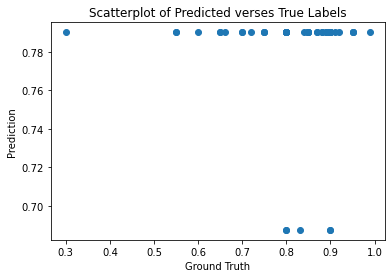

In [1849]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 1, min_samples_leaf = 8,
                                 random_state = 42)

dt_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree with 3 Params

In [1850]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train_nlp, Y_Train_nlp)
Y_Test_Pred = boosted_dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

R2 Score: -0.10782009636919776
Mean Squared Error: 0.017335168867985206


In [1851]:
#make_GridSearchCV_Boosted_DT(X_Train_nlp, Y_Train_nlp)

R2 Score: -0.0493030367258378
Mean Squared Error: 0.01641949391868591


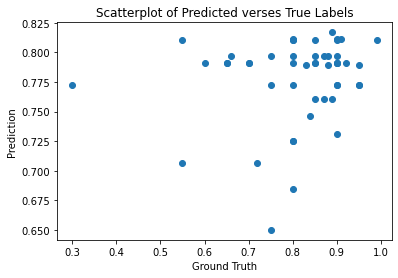

In [1852]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.6, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_nlp, Y_Train_nlp)
Y_Test_Pred = boosted_dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [1853]:
sc = StandardScaler()
X_Train_nlp = sc.fit_transform(X_Train_nlp)
X_Test_nlp = sc.transform(X_Test_nlp)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = ann_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

R2 Score: -0.2580328813294843
Mean Squared Error: 0.019685698527043768


In [1854]:
#make_GridSearchCV_ANN(X_Train_nlp, Y_Train_nlp)

R2 Score: -0.258270299262656
Mean Squared Error: 0.01968941364286204


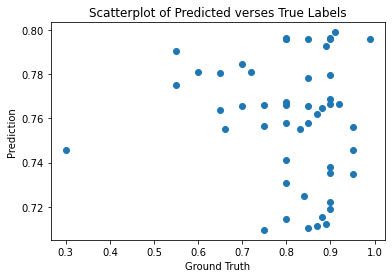

In [1855]:
sc = StandardScaler()
X_Train_nlp = sc.fit_transform(X_Train_nlp)
X_Test_nlp = sc.transform(X_Test_nlp)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         hidden_layer_sizes = 70, learning_rate_init = 0.01)

ann_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = ann_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### The Best result was using Boosted Decision Trees on the full dataset including Movie Release Year, NLTK Genre NLP Sentiment Score, KMeans Cluster Groups, and Genre Binary Indicators 

##### However, The R-Squared Value is negative. A negative R2 value means that a horizontal line is still a better predictor

### Add IMBD Dataset for additional Dimensions 

In [1856]:
meta = pd.read_csv('IMDB/movies_metadata.csv',
                  parse_dates = ['release_date'],
                  low_memory = False)

In [1857]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [1859]:
meta['release_datetime'] = pd.to_datetime(meta['release_date'],  errors='coerce', infer_datetime_format=True)
meta['release_year'] = meta['release_datetime'].dt.year
meta['release_year'] = meta['release_year'].fillna(0)

In [1862]:
meta.shape

(45466, 26)

#### Merge Datasets on Title Column

In [1863]:
data2 = pd.merge(data, meta, left_on = ['Name', 'ReleaseYear'], right_on = ['title', 'release_year'], how = 'left')

In [1868]:
print(data.shape)
print(data2.shape)


(165, 31)
(167, 57)


#### Todo: de-dupe the new dataset, based on year or something else. 

In [1869]:
data2 = data2.sort_values(by = 'vote_count', ascending = False)

In [1870]:
data3 = data2.drop_duplicates(subset = ['Name','ReleaseYear', 'WatchDate'], keep = 'first') # this keeps the movie with more ratings, probably the movie I watched

In [1871]:
data3.shape

(165, 57)

In [1872]:
data3 = data3.sort_values(by = 'WatchDate', ascending = True)

In [1873]:
data3

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,False,"{'id': 131635, 'name': 'The Hunger Games Colle...",160000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thehungergames.movie/,131634,tt1951266,en,The Hunger Games: Mockingjay - Part 2,"With the nation of Panem in a full scale war, ...",26.628178,/w93GAiq860UjmgR6tU9h2T24vaV.jpg,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2015-11-18,6.534283e+08,137.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The fire will burn forever.,The Hunger Games: Mockingjay - Part 2,False,6.6,4117.0,2015-11-18,2015.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.000000,0.0,0.000000,3,2,5,False,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,5966,tt0343135,en,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,/nIY4kvJTTnxoBR0wycrXng5MOYs.jpg,"[{'name': 'Jersey Films', 'id': 216}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-16,1.719634e+08,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"For the most cautious man on Earth, life is ab...",Along Came Polly,False,5.8,795.0,2004-01-16,2004.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,1,5,0,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-07-06,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,1994-07-06,1994.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,4,3,4,False,NaN,28000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.thebigshortmovie.com/,318846,tt1596363,en,The Big Short,The men who made millions from a global econom...,13.143061,/p11Ftd4VposrAzthkhF53ifYZRl.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-11,1.333465e+08,130.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,This is a true story.,The Big Short,False,7.3,2679.0,2015-12-11,2015.0
5,Magic in the Moonlight,0.40,2016-01-17,2014,Allen,Romance/Drama,2016-01-01,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.27870,0.000000,0.0,0.000000,4,3,4,False,NaN,16800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,229297,tt2870756,en,Magic in the Moonlight,"Set in the 1920s French Riviera, a m

In [1874]:
# Used to find proper name to join together 
meta[meta['title'].str.contains('40 Year', na = False)]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
10301,False,NaN,26000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.universalstudiosentertainment.com/t...,6957,tt0405422,en,The 40 Year Old Virgin,Andy Stitzer has a pleasant life with a nice a...,11.519662,/kFXfr0ioXRfxz4AvQ6RJ7iFF6PI.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-11,109449237.0,116.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"The longer you wait, the harder it gets",The 40 Year Old Virgin,False,6.2,2020.0,2005-08-11,2005.0


### New Data - Downloaded from IMDB, Updated Daily. This data source is more reliable than the one above; move ahead with this source

https://www.imdb.com/interfaces/


In [1876]:
os.listdir('imdb_updated')

['title.principals.tsv.gz',
 'title.ratings.tsv',
 'title.akas.tsv.gz',
 '.DS_Store',
 'title.akas.tsv',
 'title.basics.tsv.gz',
 'title.crew.tsv.gz',
 'name.basics.tsv',
 'title.ratings.tsv.gz',
 'title.basics.tsv',
 'name.basics.tsv.gz',
 'title.episode.tsv',
 'title.crew.tsv',
 'title.episode.tsv.gz']

#### IMBD Data 1 

In [2779]:
basics =  pd.read_csv('imdb_updated/title.basics.tsv', sep='\t', error_bad_lines=False)


/Users/amandahutter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2780]:
basics.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7445319,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7445320,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7445321,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7445322,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
7445323,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


In [2781]:
basics.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult            int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

In [2782]:
basics.shape

(7445324, 9)

In [2783]:
basics.isna().sum()

tconst            0
titleType         0
primaryTitle      8
originalTitle     8
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            9
dtype: int64

In [2784]:
#### Clean up IMDB Basics Data 

In [2785]:
basics = basics[basics['startYear'] != '\\N']
basics = basics[basics['titleType'] == 'movie']
basics['startYear'] = basics['startYear'].astype(int)

In [2786]:
print(min(basics['startYear']))
print(max(basics['startYear']))

1894
2028


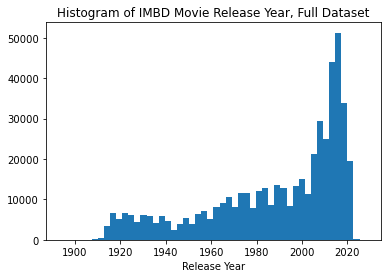

In [2787]:
plt.hist(basics['startYear'], bins = 50)
plt.title('Histogram of IMBD Movie Release Year, Full Dataset')
plt.xlabel('Release Year')
plt.show()

#### IMDB Data 2

In [2788]:
ratings = pd.read_csv('imdb_updated/title.ratings.tsv', sep = '\t', error_bad_lines = False)

In [2789]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1666
1,tt0000002,6.1,207
2,tt0000003,6.5,1385
3,tt0000004,6.2,123
4,tt0000005,6.2,2174


In [2790]:
basics_ratings = pd.merge(basics, ratings, left_on = 'tconst', right_on = 'tconst', how = 'left')

In [2791]:
print(basics.shape)
print(ratings.shape)
print(basics_ratings.shape)

(493215, 9)
(1104266, 3)
(493215, 11)


##### Try this merge 

In [2792]:
data5 = pd.merge(data, basics_ratings, left_on = ['Name', 'ReleaseYear'], right_on = ['primaryTitle', 'startYear'], how = 'left')


In [2793]:
print(data.shape)
print(data5.shape)
print('Need to de-duplicate the IMDB dataset results')

(165, 31)
(168, 42)
Need to de-duplicate the IMDB dataset results


In [2794]:
print('Number missing data:', data5['averageRating'].isna().sum())

Number missing data: 2


Use this code to find the proper title for a movie

In [2795]:
# Use this code to find the proper title for a movie
basics[basics['primaryTitle'].str.contains('Wizard of L', na = False)]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
94355,tt0096455,movie,The Wizard of Loneliness,The Wizard of Loneliness,0,1988,\N,111,Drama


'The Wizard of Lies' is a movie length TV show. We can just drop it from the data set

In [2796]:
# If it can't be found, just drop those columns 

Clean up Duplicates

In [2797]:

data5 = data5.sort_values(by = 'numVotes', ascending = False)
data6 = data5.drop_duplicates(subset = ['Name','ReleaseYear', 'WatchDate'], keep = 'first') # this keeps the movie with more ratings, probably the movie I watched
data6 = data6.sort_values(by = 'WatchDate', ascending = True)
data7 = data6.drop(columns = ['isAdult', 'originalTitle','titleType','endYear'])
#data8 = data7.rename(columns = {'averageRating':'ext_rating'})

In [2798]:
print(data7.shape)

(165, 38)


IMDB Ratings Data

In [2799]:
data7

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.9,854500.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,tt1951266,The Hunger Games: Mockingjay - Part 2,2015.0,137,"Action,Adventure,Sci-Fi",6.6,283770.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.000000,0.0,0.000000,3,2,5,tt0343135,Along Came Polly,2004.0,90,"Comedy,Romance",6.0,125593.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,1,5,0,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,4,3,4,tt1596363,The Big Short,2015.0,130,"Biography,Comedy,Drama",7.8,357633.0
5,Magic in the Moonlight,0.40,2016-01-17,2014,Allen,Romance/Drama,2016-01-01,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.27870,0.000000,0.0,0.000000,4,3,4,tt2870756,Magic in the Moonlight,2014.0,97,"Comedy,Drama,Romance",6.5,63711.0
6,Sunset Blvd.,0.55,2016-01-19,1950,Wilder,Drama/Musical,2016-01-01,Drama,Musical,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,2,6,6,tt0043014,Sunset Blvd.,1950.0,110,"Drama,Film-Noir",8.4,199896.0
7,Dr. Strangelove or: How I Learned to Stop Worr...,0.50,2016-01-20,1964,Kubrick,Fantasy/Comedy,2016-01-01,Fantasy,Comedy,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0000,0.3612,0.18060,0.000000,0.0,0.000000,1,1,1,tt0057012,Dr. Strangelove or: How I Learned to Stop Worr...,1964.0,95,Comedy,8.4,447256.0
8,The Sting,0.80,2016-01-21,1973,Hill,Crime/Drama,2016-01-01,Crime,Drama,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.5423,0.0000,-0.27115,0.000000,0.0,0.000000,6,4,3,tt0070735,The Sting,1973.0,129,"Comedy,Crime,Drama",8.3,239741.0
9,Fight Club,0.90,2016-01-29,1999,Fincher,Action/Drama,2016-01-01,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0000,0.00000,0.100000,0.0,0.050000,8,0,0,tt0137523,Fight Club,1999.0,139,Drama,8.8,1837769.0


In [2800]:
full = data7.dropna()

full.loc[:,'runtimeMinutes'] = full.loc[:,'runtimeMinutes'].astype(int)

### Explore the Relationship between this New Data and our existing Features 

Potential Columsn to add to model:
  - averageRating (how good is the movie among other people)
  - numVotes (how popular is movie among other people)
  - runtimeMinutes (how long is the movie)

In [2801]:
full.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.9,854500.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt1951266,The Hunger Games: Mockingjay - Part 2,2015.0,137,"Action,Adventure,Sci-Fi",6.6,283770.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,3,2,5,tt0343135,Along Came Polly,2004.0,90,"Comedy,Romance",6.0,125593.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,1,5,0,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,4,3,4,tt1596363,The Big Short,2015.0,130,"Biography,Comedy,Drama",7.8,357633.0


#### 1) IMDB Average Rating Verses my Rating

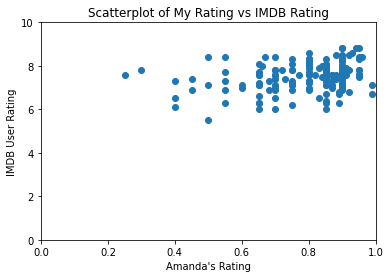

In [2802]:
plt.scatter(full['Rating'], full['averageRating'])
plt.xlim(0,1)
plt.ylim(0,10)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB User Rating')
plt.title('Scatterplot of My Rating vs IMDB Rating')
plt.show()

- There is some positive relationship between the IMDB user rating and my rating for the movie

#### 2) IMDB Viewership vs My Rating

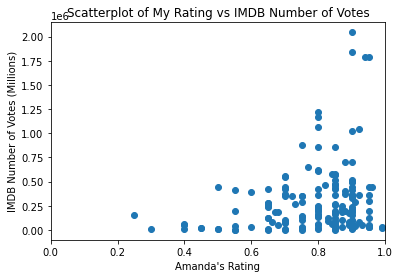

In [2803]:
plt.scatter(full['Rating'], full['numVotes'])
plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB Number of Votes (Millions)')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

#### 3) Runtime vs My Rating

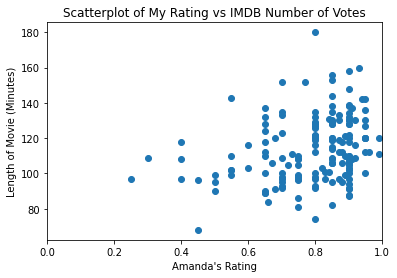

In [2804]:
plt.scatter(full['Rating'], full['runtimeMinutes'])
plt.xlim(0,1)

plt.xlabel('Amanda\'s Rating')
plt.ylabel('Length of Movie (Minutes)')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

### Recall prior variables

#### 4) Release Year vs My Rating

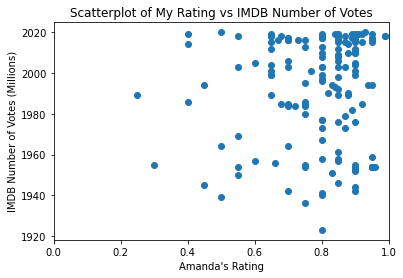

In [2805]:
plt.scatter(full['Rating'], full['startYear'])
plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('IMDB Number of Votes (Millions)')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

#### 5) NLTK Score vs My Rating

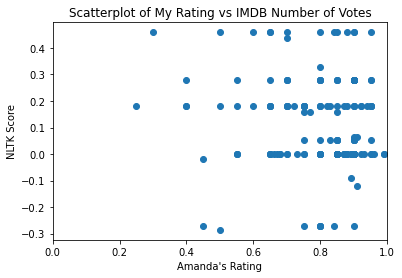

In [2806]:
plt.scatter(full['Rating'], full['Genre_NLTK'])
plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('NLTK Score')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

### We want to revisit the NLP scores using the new IMDB database genre columns - in order to get predictions from movies outside our original data -  but first, we can examine how good these 4 variables are

Split Data 

In [2807]:
X_4 = full.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating']]
y_4 = full.loc[:, 'Rating']

X_Train_4, X_Test_4, Y_Train_4, Y_Test_4 = train_test_split(X_4, y_4, test_size = .30, train_size = .70, random_state = 42)
    

### Data: IMDB 4 Features 
### Try: Decision Tree, Boosted Decision Tree, ANN

#### 1) Decision Tree

Default

In [2808]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_4, Y_Train_4)

Y_Test_Pred = dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -3.0434505464582324
Mean Squared Error: 0.036298055555555556


In [2809]:
#make_GridSearchCV_DT(X_Train_4, Y_Train_4)

Best Params

R2 Score: -0.11974313966236694
Mean Squared Error: 0.010051934164749067


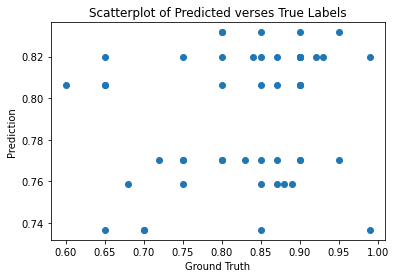

In [2810]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 6,
                                 random_state = 42)

dt_model.fit(X_Train_4, Y_Train_4)

Y_Test_Pred = dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

Default

In [2811]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = boosted_dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.9411884821956094
Mean Squared Error: 0.017426049004669986


In [2812]:
#make_GridSearchCV_Boosted_DT(X_Train_4, Y_Train_4)

Best Params

R2 Score: -0.5529806444390506
Mean Squared Error: 0.013941107245129359


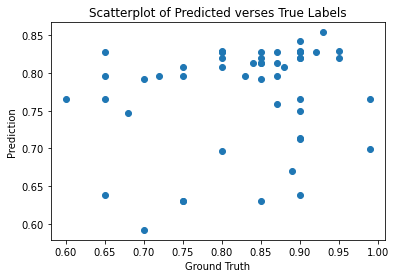

In [2813]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.9, loss = 'exponential', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_4, Y_Train_4)
Y_Test_Pred = boosted_dt_model.predict(X_Test_4)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [2814]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_4_sc, Y_Train_4)

Y_Test_Pred = ann_model.predict(X_Test_4_sc)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -4.021409561553025
Mean Squared Error: 0.045077193634061506


In [2815]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

#make_GridSearchCV_ANN(X_Train_4, Y_Train_4)

R2 Score: -0.15093562713478414
Mean Squared Error: 0.010331949124788957


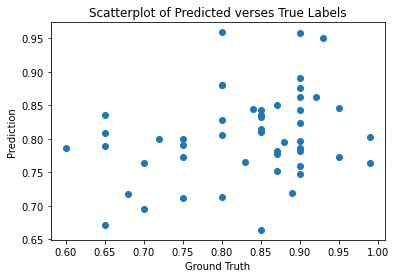

In [2816]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         learning_rate_init = 0.01, hidden_layer_sizes = (35,), max_iter=2000)

ann_model.fit(X_Train_4_sc, Y_Train_4)

Y_Test_Pred = ann_model.predict(X_Test_4_sc)

print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

plt.scatter(Y_Test_4, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) KNN

In [2817]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_4_sc, Y_Train_4)
Y_Test_Pred = knn_model.predict(X_Test_4_sc)
            
print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.13378634287623892
Mean Squared Error: 0.010177999999999998


In [2818]:
make_GridSearchCV_KNN(X_Train_4_sc, Y_Train_4)

0.007277031374879161
{'n_neighbors': 49, 'p': 1, 'weights': 'distance'}


In [2819]:
sc = StandardScaler()
X_Train_4_sc = sc.fit_transform(X_Train_4)
X_Test_4_sc = sc.transform(X_Test_4)

knn_model = KNeighborsRegressor(n_neighbors = 49, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_4_sc, Y_Train_4)
Y_Test_Pred = knn_model.predict(X_Test_4_sc)
            
print("R2 Score:", r2_score(Y_Test_4, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_4, Y_Test_Pred))

R2 Score: -0.0970060614006476
Mean Squared Error: 0.009847823413193615


### Add Back the NLP NLTK Scores for the Genre Column, using Genre from IMDB Data, not original dataset 

In [2820]:
full.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.9,854500.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt1951266,The Hunger Games: Mockingjay - Part 2,2015.0,137,"Action,Adventure,Sci-Fi",6.6,283770.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,3,2,5,tt0343135,Along Came Polly,2004.0,90,"Comedy,Romance",6.0,125593.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,1,5,0,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,4,3,4,tt1596363,The Big Short,2015.0,130,"Biography,Comedy,Drama",7.8,357633.0


#### Split out Genre Column

In [2821]:
full[['Genre_1','Genre_2','Genre_3']] = full['genres'].str.split(',',expand=True)

In [2822]:
full.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3
0,Star Wars: Episode VII - The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt2488496,Star Wars: Episode VII - The Force Awakens,2015.0,138,"Action,Adventure,Sci-Fi",7.9,854500.0,Action,Adventure,Sci-Fi
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,tt1951266,The Hunger Games: Mockingjay - Part 2,2015.0,137,"Action,Adventure,Sci-Fi",6.6,283770.0,Action,Adventure,Sci-Fi
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,3,2,5,tt0343135,Along Came Polly,2004.0,90,"Comedy,Romance",6.0,125593.0,Comedy,Romance,None
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,1,5,0,tt0109830,Forrest Gump,1994.0,142,"Drama,Romance",8.8,1789260.0,Drama,Romance,None
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,4,3,4,tt1596363,The Big Short,2015.0,130,"Biography,Comedy,Drama",7.8,357633.0,Biography,Comedy,Drama


### Use new IMDB Genre columns + NLTK to get scores to use 

In [2827]:
genre1 = list(full['Genre_1'].unique())
genre2 = list(full['Genre_2'].unique())
genre3 = list(full['Genre_3'].unique())

genre_list = list(set().union(genre1, genre2, genre3))

genre_list.remove('Music')
genre_list.remove(None)
genre_list.append('Other')

In [2828]:
#genre_list

In [2829]:

full['Mystery'] = 0 
r = re.compile(r'.*(Mystery).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Mystery'] = 1
  
full['Film-Noir'] = 0 
r = re.compile(r'.*(Film-Noir).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Film-Noir'] = 1
 
full['Horror'] = 0 
r = re.compile(r'.*(Horror).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Horror'] = 1

full['Thriller'] = 0 
r = re.compile(r'.*(Thriller).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Thriller'] = 1
 
full['Animation'] = 0 
r = re.compile(r'.*(Animation).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Animation'] = 1

full['Sci-Fi'] = 0 
r = re.compile(r'.*(Sci-Fi).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Sci-Fi'] = 1

full['Sport'] = 0 
r = re.compile(r'.*(Sport).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Sport'] = 1

full['Romance'] = 0 
r = re.compile(r'.*(Romance).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Romance'] = 1

full['Documentary'] = 0 
r = re.compile(r'.*(Documentary).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Documentary'] = 1

full['Adventure'] = 0 
r = re.compile(r'.*(Adventure).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Adventure'] = 1

# music and musical 
full['Musical'] = 0 
r = re.compile(r'.*(Music).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Musical'] = 1

full['Comedy'] = 0 
r = re.compile(r'.*(Comedy).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Comedy'] = 1

full['Crime'] = 0 
r = re.compile(r'.*(Crime).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Crime'] = 1

full['Fantasy'] = 0 
r = re.compile(r'.*(Fantasy).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Fantasy'] = 1

full['Action'] = 0 
r = re.compile(r'.*(Action).*')
full.loc[full.genres.apply(lambda x: bool(r.match(x))), 'Action'] = 1

full['History'] = 0 
r = re.compile(r'.*(History).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'History'] = 1

full['Family'] = 0 
r = re.compile(r'.*(Family).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Family'] = 1

full['Biography'] = 0 
r = re.compile(r'.*(Biography).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Biography'] = 1

full['Drama'] = 0 
r = re.compile(r'.*(Drama).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'Drama'] = 1

full['War'] = 0 
r = re.compile(r'.*(War).*')
full.loc[ full.genres.apply(lambda x: bool(r.match(x))), 'War'] = 1

full['Other'] = 0
full.loc[ (full['Mystery'] == 0) & (full['Film-Noir'] == 0) & (full['Horror'] == 0) & \
          (full['Thriller'] == 0) & (full['Animation'] == 0) & (full['Sci-Fi'] == 0) & \
         (full['Sport'] == 0) & (full['Romance'] == 0) & (full['Documentary'] == 0) & \
         (full['Adventure'] == 0) & (full['Musical'] == 0 ) & (full['Comedy'] == 0) & \
         (full['Crime'] == 0) & (full['Fantasy'] == 0) & (full['Action'] == 0) & \
         (full['History'] == 0) & (full['Family'] == 0) & (full['Biography'] == 0) & \
         (full['Drama'] == 0) & (full['War'] == 0)
         , 'Other'] = 1



### Count of each movie type 

In [2830]:
full.iloc[:,-21:].sum()

Mystery        12
Film-Noir       7
Horror          1
Thriller       15
Animation       5
Sci-Fi         10
Sport           7
Romance        42
Documentary     3
Adventure      18
Musical        19
Comedy         85
Crime          24
Fantasy        11
Action         17
History         7
Family          8
Biography      26
Drama          98
War             2
Other           0
dtype: int64

In [2831]:
full[full.Horror == 1]

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
14,Son of Frankenstein,0.5,2016-03-12,1939,Lee,Horror/Drama,2016-03-01,Horror,Drama,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.5719,0.0,-0.28595,0.0,0.0,0.0,6,4,3,tt0031951,Son of Frankenstein,1939.0,99,"Drama,Horror,Sci-Fi",7.1,9043.0,Drama,Horror,Sci-Fi,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [2832]:
full[full.War == 1]

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
92,Casablanca,0.90,2019-02-13,1942,Michael Curtiz,Romance/Drama,2019-02-01,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.2787,0.0,0.0,0.0,5,1,1,tt0034583,Casablanca,1942.0,102,"Drama,Romance,War",8.5,517765.0,Drama,Romance,War,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
127,Jojo Rabbit,0.91,2020-04-17,2019,Waitiki,War/Comedy,2020-04-01,War,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.5994,0.3612,-0.1191,0.0,0.0,0.0,0,0,2,tt2584384,Jojo Rabbit,2019.0,108,"Comedy,Drama,War",7.9,284488.0,Comedy,Drama,War,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [2833]:
full[full.Documentary == 1]

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Mystery,Film-Noir,Horror,Thriller,Animation,Sci-Fi,Sport,Romance,Documentary,Adventure,Musical,Comedy,Crime,Fantasy,Action,History,Family,Biography,Drama,War,Other
98,Knock Down the House,0.90,2019-05-07,2019,Rachel Lears,Documentary/Political,2019-05-01,Documentary,Political,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,tt9358052,Knock Down the House,2019.0,87,Documentary,7.1,11283.0,Documentary,None,None,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
107,"Monrovia, Indiana",0.55,2019-07-16,2018,Frederick Wiseman,Documentary,2019-07-01,Documentary,Genre1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,tt8749146,"Monrovia, Indiana",2018.0,143,Documentary,6.9,508.0,Documentary,None,None,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
140,13th,0.90,2020-06-11,2016,Ava DuVernay,Documentary/History,2020-06-01,Documentary,History,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2,tt5895028,13th,2016.0,100,"Crime,Documentary,History",8.3,31166.0,Crime,Documentary,History,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0


#### Consolidate the columns

In [2834]:
full.loc[(full['Horror'] == 1) |(full['War'] == 1) | (full['Documentary'] == 1) |
         (full['Animation'] == 1) | (full['Film-Noir'] == 1) | (full['Sport'] == 1) |
         (full['History'] == 1) & (full['Family'] == 1) , "Other"] = 1

full = full.drop(columns = ['Horror','Documentary','War', 'Animation', 'Film-Noir', 'Sport', 'History', 'Family'])

genre_list.remove('Horror')
genre_list.remove('War')
genre_list.remove('Documentary')

genre_list.remove('Animation')
genre_list.remove('Film-Noir')
genre_list.remove('Sport')
genre_list.remove('History')
genre_list.remove('Family')

In [2835]:
full[full.Comedy == 1]['Rating'].mean()

0.7655294117647058

In [2836]:
for i in range(0, len(genre_list)):
    genre = genre_list[i]
    print(genre + " : " + str(full[full[genre] == 1]['Rating'].mean()))
    

Mystery : 0.8758333333333335
Thriller : 0.856
Sci-Fi : 0.7949999999999999
Romance : 0.7871428571428571
Adventure : 0.7966666666666667
Comedy : 0.7655294117647058
Crime : 0.7999999999999999
Fantasy : 0.7663636363636364
Action : 0.7647058823529413
Musical : 0.8463157894736844
Biography : 0.8565384615384615
Drama : 0.8021428571428576
Other : 0.7600000000000001


In [2837]:
full.iloc[:,-13:].sum()

Mystery      12
Thriller     15
Sci-Fi       10
Romance      42
Adventure    18
Musical      19
Comedy       85
Crime        24
Fantasy      11
Action       17
Biography    26
Drama        98
Other        25
dtype: int64

In [2838]:
# Replace Blanks with filling forward Genre 1 and Genre 2 
full['Genre_2'] = full['Genre_2'].fillna(full['Genre_1'])
full['Genre_3'] = full['Genre_3'].fillna(full['Genre_1'])

### Use NLTK Vader Score, from Prior Analysis, to get sentiment of each column

In [2839]:
# Apply this function to my Genre Columns
full['Genre_1_NLTK'] = full['Genre_1'].apply(get_vader_score)
full['Genre_2_NLTK'] = full['Genre_2'].apply(get_vader_score)
full['Genre_3_NLTK'] = full['Genre_3'].apply(get_vader_score)
full['Genres_NLTK'] = (full['Genre_1_NLTK'] + full['Genre_2_NLTK'] + full['Genre_3_NLTK'] ) / 3

#### Histograms of Genre NLTK Scores using IMDB genres column

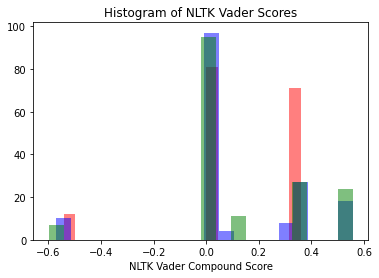

In [2840]:
plt.hist(full['Genre_1_NLTK'], bins = 20, color = 'red', alpha = .5)
plt.hist(full['Genre_2_NLTK'], bins = 20, color = 'blue', alpha = .5)
plt.hist(full['Genre_3_NLTK'], bins = 20, color = 'green', alpha = .5)

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

#### Histogram of Average Genre NLTK Score using IMDB Genres Column

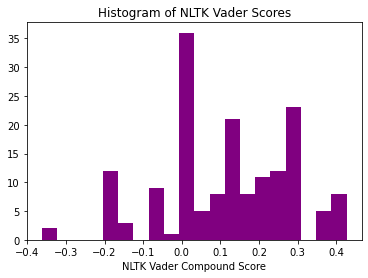

In [2841]:
plt.hist(full['Genres_NLTK'], bins = 20, color = 'purple')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

#### Histogram Comparing NLTK Score using the 3 Genre columns from IMDB, verses the Manual 2 Genres from my original Dataset

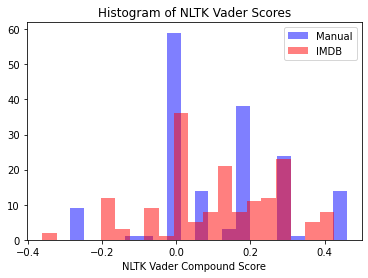

In [2842]:
plt.hist(full['Genre_NLTK'], bins = 20, color = 'blue', alpha = .5, label = 'Manual')
plt.hist(full['Genres_NLTK'], bins = 20, color = 'red', alpha = .5, label = 'IMDB')

plt.legend()
plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

- The IMDB Genre column gives data that is more spaced out than my manual data column, with much lower peaks

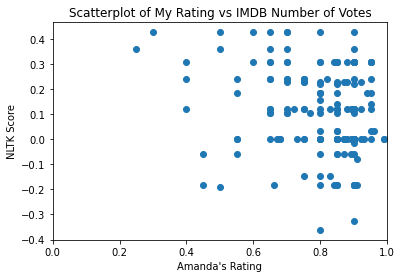

In [2843]:
plt.scatter(full['Rating'], full['Genres_NLTK'])
plt.xlim(0,1)
plt.xlabel('Amanda\'s Rating')
plt.ylabel('NLTK Score')
plt.title('Scatterplot of My Rating vs IMDB Number of Votes')
plt.show()

### Data: IMDB 4 Features + NLTK Score on IMDB Genres Column


In [2844]:
X_5 = full.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK']]
y_5 = full.loc[:, 'Rating']

X_Train_5, X_Test_5, Y_Train_5, Y_Test_5 = train_test_split(X_5, y_5, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree with IMDB Data

Default

In [2845]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_5, Y_Train_5)

Y_Test_Pred = dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -2.029860260171054
Mean Squared Error: 0.027199055555555553


In [2846]:
make_GridSearchCV_DT(X_Train_5, Y_Train_5)

-0.002479837894741799
{'criterion': 'mae', 'max_depth': 3, 'min_samples_leaf': 6, 'splitter': 'best'}


R2 Score: -1.1186922134343318
Mean Squared Error: 0.019019499999999998


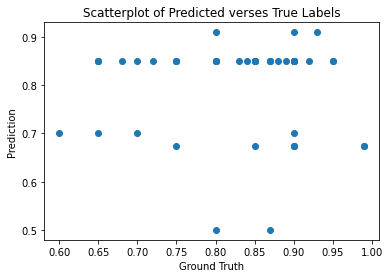

In [2847]:
dt_model = DecisionTreeRegressor(criterion = 'mae', splitter = 'best', 
                                 max_depth = 3, min_samples_leaf = 6,
                                 random_state = 42)

dt_model.fit(X_Train_5, Y_Train_5)

Y_Test_Pred = dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

Default

In [2848]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = boosted_dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -0.6046890455883125
Mean Squared Error: 0.014405293562246282


In [2849]:
#make_GridSearchCV_Boosted_DT(X_Train_5, Y_Train_5)

Best Params

R2 Score: -0.4729436653226502
Mean Squared Error: 0.01322261528360143


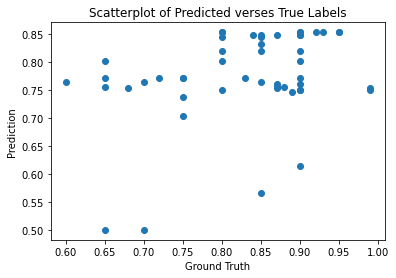

In [2850]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = boosted_dt_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [2851]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_5_sc, Y_Train_5)

Y_Test_Pred = ann_model.predict(X_Test_5_sc)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -4.442177572038264
Mean Squared Error: 0.0488544280641875


In [2852]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

#make_GridSearchCV_ANN(X_Train_5_sc, Y_Train_5)

Best Params

R2 Score: -1.027920976795063
Mean Squared Error: 0.01820464660868928


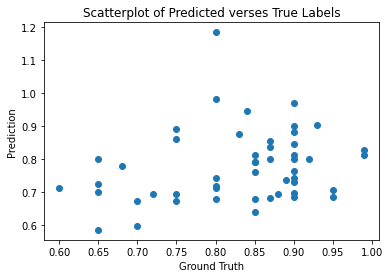

In [2853]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42,
                         hidden_layer_sizes = (10,), learning_rate_init = 0.05)

ann_model.fit(X_Train_5_sc, Y_Train_5)

Y_Test_Pred = ann_model.predict(X_Test_5_sc)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) Random Forest

In [2854]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = rf_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -0.5282224180863349
Mean Squared Error: 0.013718852647161028


In [2855]:
def make_GridSearchCV_RF(X_Train, Y_Train):

    #num_est = np.arange(10,100,step=5)
    num_est = [50, 100]
    criterions = ['mse']
    #max_depths = list(np.arange(1, 20, 2))
    max_depths = list(np.arange(3, 20, 2))
    #min_samples_leaf = list(np.arange(10, 20, 1))
    min_samples_leaf = list(np.arange(10, 20, 1))
    
    param_grid = {'n_estimators': num_est, 'criterion': criterions,
                 'max_depth': max_depths, 'min_samples_leaf': min_samples_leaf}

    classifier = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [2856]:
#make_GridSearchCV_RF(X_Train_5, Y_Train_5)

R2 Score: -0.7245747154656941
Mean Squared Error: 0.015481507220735538


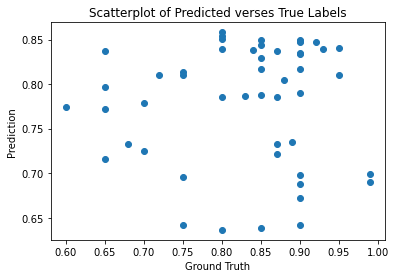

In [2857]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = 5, min_samples_leaf = 12)

rf_model.fit(X_Train_5, Y_Train_5)
Y_Test_Pred = rf_model.predict(X_Test_5)

print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

plt.scatter(Y_Test_5, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### The most important columns

In [2858]:

# How many features do we need to get 95% of feature importance? 
def run_RFR(X_Data, Y_Data, n_est, min_samples, max_depth):
    
    rfr = RandomForestRegressor(n_estimators=n_est, min_samples_leaf=min_samples, max_depth = max_depth, criterion = 'mse',
                                random_state=42)
    
    importances = rfr.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    #return (importances, top_cols)
    return importances

In [2859]:
run_RFR(X_Train_5, Y_Train_5, 100, 12, 5)

,Feature Importance,Cum Sum
numVotes,0.454626,0.454626
runtimeMinutes,0.324565,0.779190
averageRating,0.120775,0.899965


#### 5) KNN

In [2860]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)
Y_Test_Pred = knn_model.predict(X_Test_5_sc)
            
print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -0.14618246630277398
Mean Squared Error: 0.010289280000000003


In [2861]:
def make_GridSearchCV_KNN(X_Train, Y_Train):
    
    ks = np.arange(1, 90, step = 2)
    ps = np.arange(1, 3, step = 1)

    weights = ['uniform', 'distance'] 
    param_grid = { 'n_neighbors': ks, 'weights': weights, 'p': ps}

    classifier = GridSearchCV(KNeighborsRegressor(),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [2862]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

make_GridSearchCV_KNN(X_Train_5_sc, Y_Train_5)

0.0052617079488177735
{'n_neighbors': 57, 'p': 1, 'weights': 'distance'}


In [2863]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

knn_model = KNeighborsRegressor(n_neighbors = 57, weights = 'distance', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)
Y_Test_Pred = knn_model.predict(X_Test_5_sc)
            
print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: 0.013817976332609505
Mean Squared Error: 0.008852956026462166


In [2864]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Test_5_sc = sc.transform(X_Test_5)

knn_model = KNeighborsRegressor(n_neighbors = 57, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)
Y_Test_Pred = knn_model.predict(X_Test_5_sc)
            
print("R2 Score:", r2_score(Y_Test_5, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_5, Y_Test_Pred))

R2 Score: -0.007840660091189333
Mean Squared Error: 0.009047385605638607


### Data: IMDB 4 Features + NLTK Average Score + 21 binary indicators

In [2865]:
#full.columns

In [2866]:
X_6 = full.loc[:, [
                    'startYear','numVotes','averageRating','Genres_NLTK',
                    #'startYear','numVotes','averageRating',
                   #'startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK',
                  'Mystery', 'Thriller', 'Sci-Fi', 'Romance',
           'Adventure', 'Musical', 'Comedy', 'Crime', 'Fantasy', 'Action',
           'Biography', 'Drama', 'Other']]

y_6 = full.loc[:, 'Rating']

X_Train_6, X_Test_6, Y_Train_6, Y_Test_6 = train_test_split(X_6, y_6, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree

In [2867]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))



R2 Score: -2.2045845555926866
Mean Squared Error: 0.02876755555555555


In [2868]:
#make_GridSearchCV_DT(X_Train_6, Y_Train_6)

R2 Score: -1.1186922134343318
Mean Squared Error: 0.019019499999999998


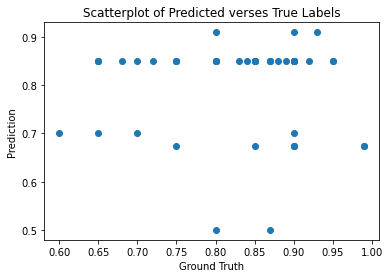

In [2869]:
dt_model = DecisionTreeRegressor(criterion = 'mae', splitter = 'best', 
                                 max_depth = 3, min_samples_leaf = 6,
                                 random_state = 42)

dt_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted DT

In [2870]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = boosted_dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -0.5986765840308519
Mean Squared Error: 0.014351319694844957


In [2871]:
#make_GridSearchCV_Boosted_DT(X_Train_6, Y_Train_6)

R2 Score: -0.7746665144681637
Mean Squared Error: 0.015931181300380706


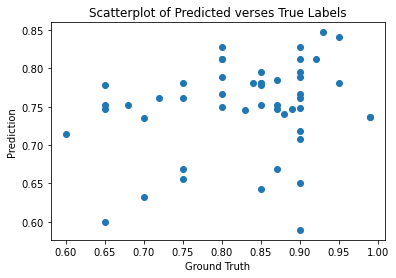

In [2872]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 40, learning_rate = 0.7, loss = 'exponential', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = boosted_dt_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [2873]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_6_sc, Y_Train_6)

Y_Test_Pred = ann_model.predict(X_Test_6_sc)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -1.2104383635954248
Mean Squared Error: 0.01984310518999613


In [2874]:
#make_GridSearchCV_ANN(X_Train_6, Y_Train_6)

R2 Score: -0.5816921492330092
Mean Squared Error: 0.014198850423664724


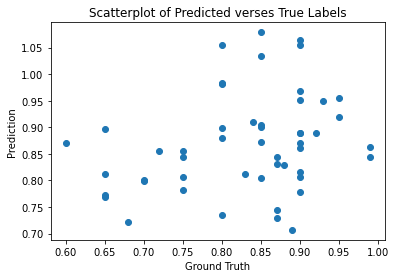

In [2875]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         learning_rate_init = 0.01, hidden_layer_sizes = (5, ))

ann_model.fit(X_Train_6_sc, Y_Train_6)

Y_Test_Pred = ann_model.predict(X_Test_6_sc)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 4) Random Forest 

In [2876]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 100,
                                max_depth = None, min_samples_leaf = 1)
rf_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = rf_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -0.4043973585119447
Mean Squared Error: 0.012607275087361728


In [2877]:
#make_GridSearchCV_RF(X_Train_6, Y_Train_6)

R2 Score: -0.8868329184520336
Mean Squared Error: 0.016938099108943908


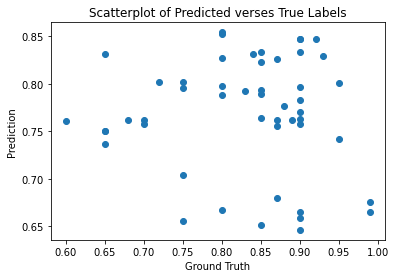

In [2878]:
rf_model = RandomForestRegressor(random_state = 42, criterion = 'mse', n_estimators = 50,
                                max_depth = 5, min_samples_leaf = 12)

rf_model.fit(X_Train_6, Y_Train_6)
Y_Test_Pred = rf_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

In [2879]:
run_RFR(X_Train_6, Y_Train_6, 50, 12, 5)

,Feature Importance,Cum Sum
numVotes,0.532273,0.532273
Genres_NLTK,0.176166,0.708439
averageRating,0.121286,0.829725
startYear,0.113586,0.943311


- 4 Features provide 95% of the feature importance. 
- We get 94% of the feature importance without using the Binary Columns

#### 5) XGBoost Tree

In [2880]:
data_dmatrix = xgboost.DMatrix(data=X_6,label=y_6)

xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = xgb_model.predict(X_Test_6)

print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))


R2 Score: -4.870683814117233
Mean Squared Error: 0.052701128599330405


In [2881]:
def make_GridSearchCV_XGB(X_Train, Y_Train):
    
    learning_rates = np.arange(.1, 1, 0.1)
    max_depths = np.arange(3, 10, 2)
    num_estimators = np.arange(10, 100, 10)
    objectives = ['reg:squarederror', 'reg:logistic']
    
    param_grid = {'learning_rate': learning_rates, 'n_estimators': num_estimators,
                 'max_depth': max_depths, 'objective': objectives}

    classifier = GridSearchCV(xgboost.XGBRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)

In [2882]:
#make_GridSearchCV_XGB(X_Train_6, Y_Train_6)

In [2883]:
data_dmatrix = xgboost.DMatrix(data=X_6,label=y_6)

xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.4,
                max_depth = 3, alpha = 10, n_estimators = 10)

xgb_model.fit(X_Train_6, Y_Train_6)

Y_Test_Pred = xgb_model.predict(X_Test_6)


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.4,
                'max_depth': 3, 'alpha': 10}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#cv_results

R2 Score: -2.4229724021000374
Mean Squared Error: 0.03072802325365204


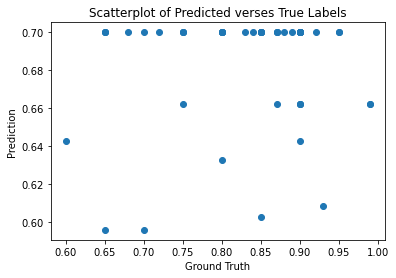

In [2884]:
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 6) SVM 

In [2885]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

svm_model = SVR(C = 1.0, kernel = 'rbf', degree = 3)
svm_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_red = svm_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -2.4229724021000374
Mean Squared Error: 0.03072802325365204


In [2886]:
def make_GridSearchCV_SVM(X_Train, Y_Train):
    
    cs = [1,10]
    #cs = [1]
    kernels = ['linear','rbf', 'poly']
    degrees = [2, 3, 4]
    #degrees = [ 3]
    
    param_grid = {'C': cs, 'kernel': kernels, 'degree': degrees}

    classifier = GridSearchCV(SVR(),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    

In [2887]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

make_GridSearchCV_SVM(X_Train_6_sc, Y_Train_6)

0.10748531772390926
{'C': 1, 'degree': 2, 'kernel': 'linear'}


Best Params

R2 Score: -0.339560316170479
Mean Squared Error: 0.01202523295826239


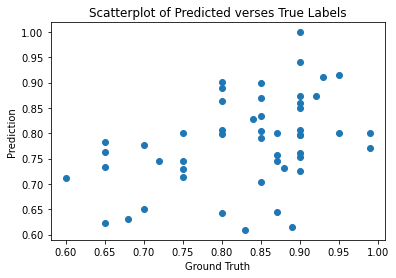

In [2888]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

svm_model = SVR(C = 1.0, kernel = 'linear', degree = 2)
svm_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = svm_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 7) KNN 

Default

In [2889]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = knn_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

R2 Score: -0.24731201960565907
Mean Squared Error: 0.011197120000000003


In [2890]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

make_GridSearchCV_KNN(X_Train_6_sc, Y_Train_6)

0.007703398615526979
{'n_neighbors': 21, 'p': 2, 'weights': 'distance'}


R2 Score: -0.02183155921024027
Mean Squared Error: 0.009172981907030326


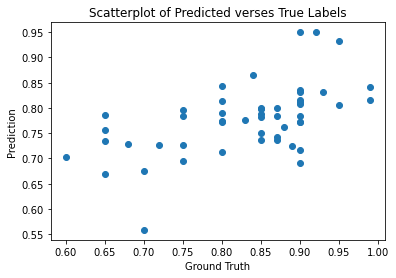

In [2891]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Test_6_sc = sc.transform(X_Test_6)

knn_model = KNeighborsRegressor(n_neighbors = 21, weights = 'distance', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_6_sc, Y_Train_6)
Y_Test_Pred = knn_model.predict(X_Test_6_sc)
            
print("R2 Score:", r2_score(Y_Test_6, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_6, Y_Test_Pred))

plt.scatter(Y_Test_6, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### Data: Remove the Release Year, not found to be useful

In [2892]:
X_7 = full.loc[:, ['startYear','numVotes','averageRating','Genres_NLTK']]
y_7 = full.loc[:, 'Rating']

X_Train_7, X_Test_7, Y_Train_7, Y_Test_7 = train_test_split(X_7, y_7, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree

In [2893]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_7, Y_Train_7)

Y_Test_Pred = dt_model.predict(X_Test_7)

print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))



R2 Score: -1.5324223633235547
Mean Squared Error: 0.022733555555555552


In [2894]:
make_GridSearchCV_DT(X_Train_7, Y_Train_7)

0.046485941515393425
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 5, 'splitter': 'best'}


R2 Score: -0.8523564307127587
Mean Squared Error: 0.016628603678508436


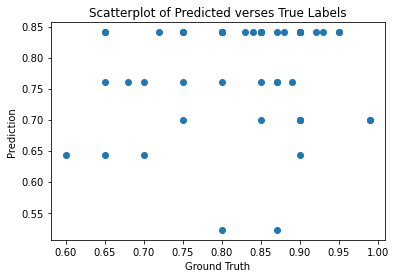

In [2895]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = 3, min_samples_leaf = 5,
                                 random_state = 42)

dt_model.fit(X_Train_7, Y_Train_7)

Y_Test_Pred = dt_model.predict(X_Test_7)

print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

plt.scatter(Y_Test_7, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 7) KNN

In [2896]:
sc = StandardScaler()
X_Train_7_sc = sc.fit_transform(X_Train_7)
X_Test_7_sc = sc.transform(X_Test_7)

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_7_sc, Y_Train_7)
Y_Test_Pred = knn_model.predict(X_Test_7_sc)
            
print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

R2 Score: -0.5945015038431545
Mean Squared Error: 0.014313839999999998


In [2897]:
make_GridSearchCV_KNN(X_Train_7_sc, Y_Train_7)

-0.02217681670158589
{'n_neighbors': 45, 'p': 1, 'weights': 'distance'}


R2 Score: -0.05370863150052263
Mean Squared Error: 0.009459142384980192


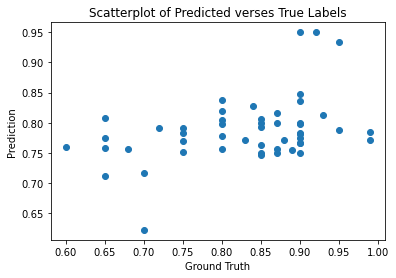

In [2898]:
sc = StandardScaler()
X_Train_7_sc = sc.fit_transform(X_Train_7)
X_Test_7_sc = sc.transform(X_Test_7)

knn_model = KNeighborsRegressor(n_neighbors = 45, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_7_sc, Y_Train_7)
Y_Test_Pred = knn_model.predict(X_Test_7_sc)
            
print("R2 Score:", r2_score(Y_Test_7, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_7, Y_Test_Pred))

plt.scatter(Y_Test_7, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### Final Step: Get Some Movie Recommendations 

Based on the model developed above, use the model to rank the IMDB Dataset and get some movie recommendations

In [2899]:
basics_ratings.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,6.0,154.0
1,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",6.0,39.0
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.5,8.0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",6.1,607.0
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.5,14.0


In [2900]:
basics_ratings.shape

(493215, 11)

#### Keep same pre-processing we used to build the model

In [2901]:
basics_ratings[['Genre_1','Genre_2','Genre_3']] = basics_ratings['genres'].str.split(',',expand=True)

# Replace Blanks with filling forward Genre 1 and Genre 2 
basics_ratings['Genre_2'] = basics_ratings['Genre_2'].fillna(basics_ratings['Genre_1'])
basics_ratings['Genre_3'] = basics_ratings['Genre_3'].fillna(basics_ratings['Genre_1'])

In [2902]:
# Apply this function to my Genre Columns
basics_ratings['Genre_1_NLTK'] = basics_ratings['Genre_1'].apply(get_vader_score)
basics_ratings['Genre_2_NLTK'] = basics_ratings['Genre_2'].apply(get_vader_score)
basics_ratings['Genre_3_NLTK'] = basics_ratings['Genre_3'].apply(get_vader_score)
basics_ratings['Genres_NLTK'] = (basics_ratings['Genre_1_NLTK'] + basics_ratings['Genre_2_NLTK'] + basics_ratings['Genre_3_NLTK'] ) / 3

In [2903]:

basics_ratings['Mystery'] = 0 
r = re.compile(r'.*(Mystery).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Mystery'] = 1
  
basics_ratings['Film-Noir'] = 0 
r = re.compile(r'.*(Film-Noir).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Film-Noir'] = 1
 
basics_ratings['Horror'] = 0 
r = re.compile(r'.*(Horror).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Horror'] = 1

basics_ratings['Thriller'] = 0 
r = re.compile(r'.*(Thriller).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Thriller'] = 1
 
basics_ratings['Animation'] = 0 
r = re.compile(r'.*(Animation).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Animation'] = 1

basics_ratings['Sci-Fi'] = 0 
r = re.compile(r'.*(Sci-Fi).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Sci-Fi'] = 1

basics_ratings['Sport'] = 0 
r = re.compile(r'.*(Sport).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Sport'] = 1

basics_ratings['Romance'] = 0 
r = re.compile(r'.*(Romance).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Romance'] = 1

basics_ratings['Documentary'] = 0 
r = re.compile(r'.*(Documentary).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Documentary'] = 1

basics_ratings['Adventure'] = 0 
r = re.compile(r'.*(Adventure).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Adventure'] = 1

# music and musical 
basics_ratings['Musical'] = 0 
r = re.compile(r'.*(Music).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Musical'] = 1

basics_ratings['Comedy'] = 0 
r = re.compile(r'.*(Comedy).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Comedy'] = 1

basics_ratings['Crime'] = 0 
r = re.compile(r'.*(Crime).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Crime'] = 1

basics_ratings['Fantasy'] = 0 
r = re.compile(r'.*(Fantasy).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Fantasy'] = 1

basics_ratings['Action'] = 0 
r = re.compile(r'.*(Action).*')
basics_ratings.loc[basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Action'] = 1

basics_ratings['History'] = 0 
r = re.compile(r'.*(History).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'History'] = 1

basics_ratings['Family'] = 0 
r = re.compile(r'.*(Family).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Family'] = 1

basics_ratings['Biography'] = 0 
r = re.compile(r'.*(Biography).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Biography'] = 1

basics_ratings['Drama'] = 0 
r = re.compile(r'.*(Drama).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'Drama'] = 1

basics_ratings['War'] = 0 
r = re.compile(r'.*(War).*')
basics_ratings.loc[ basics_ratings.genres.apply(lambda x: bool(r.match(x))), 'War'] = 1

basics_ratings['Other'] = 0
basics_ratings.loc[ (basics_ratings['Mystery'] == 0) & (basics_ratings['Film-Noir'] == 0) & \
                   (basics_ratings['Horror'] == 0) & (basics_ratings['Documentary'] == 0) & (basics_ratings['War'] == 0) & \
          (basics_ratings['Thriller'] == 0) & (basics_ratings['Animation'] == 0) & (basics_ratings['Sci-Fi'] == 0) & \
         (basics_ratings['Sport'] == 0) & \
        (basics_ratings['Romance'] == 0) &  \
         (basics_ratings['Adventure'] == 0) & (basics_ratings['Musical'] == 0 ) & (basics_ratings['Comedy'] == 0) & \
         (basics_ratings['Crime'] == 0) & (basics_ratings['Fantasy'] == 0) & (basics_ratings['Action'] == 0) & \
         (basics_ratings['History'] == 0) & (basics_ratings['Family'] == 0) & (basics_ratings['Biography'] == 0) & \
         (basics_ratings['Drama'] == 0) , 'Other'] = 1



In [2904]:
basics_ratings.iloc[:,-21:].sum()

Mystery         12559
Film-Noir         784
Horror          23087
Thriller        27458
Animation        6165
Sci-Fi           7908
Sport            5307
Romance         39139
Documentary     95902
Adventure       21811
Musical         18411
Comedy          86483
Crime           29025
Fantasy         10533
Action          39925
History         11128
Family          14033
Biography       12679
Drama          179085
War              7817
Other           77287
dtype: int64

In [2905]:
basics_ratings.loc[(basics_ratings['Horror'] == 1) |(basics_ratings['War'] == 1) | (basics_ratings['Documentary'] == 1) |
         (basics_ratings['Animation'] == 1) | (basics_ratings['Film-Noir'] == 1) | (basics_ratings['Sport'] == 1) |
         (basics_ratings['History'] == 1) & (basics_ratings['Family'] == 1) , "Other"] = 1

basics_ratings = basics_ratings.drop(columns = ['Horror','Documentary','War', 'Animation', 'Film-Noir', 'Sport', 'History', 'Family'])



#### Best Model - Random Forest with 6 variables 

In [2906]:
basics_ratings = basics_ratings.dropna()
basics_ratings = basics_ratings[basics_ratings['runtimeMinutes'] != "\\N"]

X_Valid_6 = basics_ratings.loc[:, [
       # 'startYear', 'runtimeMinutes', 'numVotes', 'averageRating', 'Genres_NLTK',
       'startYear', 'numVotes', 'averageRating', 'Genres_NLTK',
        #'startYear', 'numVotes', 'averageRating',
        'Mystery', 'Thriller', 'Sci-Fi', 'Romance', 'Adventure',
       'Musical', 'Comedy', 'Biography', 'Drama',
       'Other', 'Crime', 'Fantasy', 'Action']]

X_Valid_5 = basics_ratings.loc[:, ['startYear','runtimeMinutes','numVotes','averageRating','Genres_NLTK']]


In [2778]:
sc = StandardScaler()
X_Train_6_sc = sc.fit_transform(X_Train_6)
X_Valid_6_sc = sc.transform(X_Valid_6)

knn_model = KNeighborsRegressor(n_neighbors = 13, weights = 'distance', p = 1, algorithm = 'auto')
knn_model.fit(X_Train_6_sc, Y_Train_6)

Y_Valid_Pred = knn_model.predict(X_Valid_6_sc)

#### This one is best, using just 5 variables

In [2909]:
sc = StandardScaler()
X_Train_5_sc = sc.fit_transform(X_Train_5)
X_Valid_5_sc = sc.transform(X_Valid_5)

knn_model = KNeighborsRegressor(n_neighbors = 29, weights = 'distance', p = 2, algorithm = 'auto')
knn_model.fit(X_Train_5_sc, Y_Train_5)

# New Validation Set
Y_Valid_Pred = knn_model.predict(X_Valid_5_sc)

In [2910]:
basics_ratings['pred_rating'] = Y_Valid_Pred

#### The Highest Rated Movies, according to my model

In [2926]:
basics_ratings.sort_values(by = 'pred_rating', ascending = False).head(15)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Genre_1_NLTK,Genre_2_NLTK,Genre_3_NLTK,Genres_NLTK,Mystery,Thriller,Sci-Fi,Romance,Adventure,Musical,Comedy,Crime,Fantasy,Action,Biography,Drama,Other,pred_rating
33916,tt0047396,movie,Rear Window,Rear Window,0,1954,\N,112,"Mystery,Thriller",8.4,440373.0,Mystery,Thriller,Mystery,0.0000,0.1027,0.0000,0.034233,1,1,0,0,0,0,0,0,0,0,0,0,0,0.955000
407686,tt4846340,movie,Hidden Figures,Hidden Figures,0,2016,\N,127,"Biography,Drama,History",7.8,197949.0,Biography,Drama,History,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.950000
420833,tt5462602,movie,The Big Sick,The Big Sick,0,2017,\N,120,"Comedy,Drama,Romance",7.5,119925.0,Comedy,Drama,Romance,0.3612,0.0000,0.5574,0.306200,0,0,0,1,0,0,1,0,0,0,0,1,0,0.950000
306032,tt1596363,movie,The Big Short,The Big Short,0,2015,\N,130,"Biography,Comedy,Drama",7.8,357633.0,Biography,Comedy,Drama,0.0000,0.3612,0.0000,0.120400,0,0,0,0,0,0,1,0,0,0,1,1,0,0.950000
475895,tt8637428,movie,The Farewell,The Farewell,0,2019,\N,100,"Comedy,Drama",7.6,48734.0,Comedy,Drama,Comedy,0.3612,0.0000,0.3612,0.240800,0,0,0,0,0,0,1,0,0,0,0,1,0,0.950000
76838,tt0109830,movie,Forrest Gump,Forrest Gump,0,1994,\N,142,"Drama,Romance",8.8,1789260.0,Drama,Romance,Drama,0.0000,0.5574,0.0000,0.185800,0,0,0,1,0,0,0,0,0,0,0,1,0,0.945000
34155,tt0047673,movie,White Christmas,White Christmas,0,1954,\N,120,"Comedy,Musical,Romance",7.6,32649.0,Comedy,Musical,Romance,0.3612,0.0000,0.5574,0.306200,0,0,0,1,0,1,1,0,0,0,0,0,0,0.933333
439408,tt6394270,movie,Bombshell,Bombshell,0,2019,\N,109,"Biography,Drama",6.8,83492.0,Biography,Drama,Biography,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,1,1,0,0.920000
63603,tt0088763,movie,Back to the Future,Back to the Future,0,1985,\N,116,"Adventure,Comedy,Sci-Fi",8.5,1047525.0,Adventure,Comedy,Sci-Fi,0.3182,0.3612,0.0000,0.226467,0,0,1,0,1,0,1,0,0,0,0,0,0,0.920000
353792,tt2584384,movie,Jojo Rabbit,Jojo Rabbit,0,2019,\N,108,"Comedy,Drama,War",7.9,284488.0,Comedy,Drama,War,0.3612,0.0000,-0.5994,-0.079400,0,0,0,0,0,0,1,0,0,0,0,1,1,0.910000


### Top 100 Movies that I should see, based on my algorithm

In [2927]:
watched_list = full['Name'].unique()
to_watch = basics_ratings[~basics_ratings['primaryTitle'].isin(watched_list)]

to_watch.sort_values(by = 'pred_rating', ascending = False).head(200)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Genre_1,Genre_2,Genre_3,Genre_1_NLTK,Genre_2_NLTK,Genre_3_NLTK,Genres_NLTK,Mystery,Thriller,Sci-Fi,Romance,Adventure,Musical,Comedy,Crime,Fantasy,Action,Biography,Drama,Other,pred_rating
77503,tt0110912,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama",8.9,1809876.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.871752
77665,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2320032.0,Drama,Drama,Drama,0.0000,0.0000,0.0000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0.868250
89420,tt0133093,movie,The Matrix,The Matrix,0,1999,\N,136,"Action,Sci-Fi",8.7,1660273.0,Action,Sci-Fi,Action,0.0000,0.0000,0.0000,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0.866101
70621,tt0099685,movie,Goodfellas,Goodfellas,0,1990,\N,146,"Biography,Crime,Drama",8.7,1010189.0,Biography,Crime,Drama,0.0000,-0.5423,0.0000,-0.180767,0,0,0,0,0,0,0,1,0,0,1,1,0,0.864652
209324,tt0468569,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",9.0,2282070.0,Action,Crime,Drama,0.0000,-0.5423,0.0000,-0.180767,0,0,0,0,0,0,0,1,0,1,0,1,0,0.864097
212192,tt0482571,movie,The Prestige,The Prestige,0,2006,\N,130,"Drama,Mystery,Sci-Fi",8.5,1178129.0,Drama,Mystery,Sci-Fi,0.0000,0.0000,0.0000,0.000000,1,0,1,0,0,0,0,0,0,0,0,1,0,0.862054
79355,tt0114369,movie,Se7en,Se7en,0,1995,\N,127,"Crime,Drama,Mystery",8.6,1429977.0,Crime,Drama,Mystery,-0.5423,0.0000,0.0000,-0.180767,1,0,0,0,0,0,0,1,0,0,0,1,0,0.861762
50100,tt0068646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1602199.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.858779
168793,tt0317248,movie,City of God,Cidade de Deus,0,2002,\N,130,"Crime,Drama",8.6,694651.0,Crime,Drama,Crime,-0.5423,0.0000,-0.5423,-0.361533,0,0,0,0,0,0,0,1,0,0,0,1,0,0.858730
58287,tt0080684,movie,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode V - The Empire Strikes Back,0,1980,\N,124,"Action,Adventure,Fantasy",8.7,1148983.0,Action,Adventure,Fantasy,0.0000,0.3182,0.0000,0.106067,0,0,0,0,1,0,0,0,1,1,0,0,0,0.856744


Try this blog post: https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/